# <수산시장(중간관광거점) 리뷰 감성분석>
군산의 새만금종합수산시장(중간관광거점)의 리뷰를 구글맵에서 크롤링 해와 감성분석을 진행하고 그 결과를 워드클라우드로 시각화하였습니다.

In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 231 kB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 448 kB 57.7 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-09-14 16:25:12--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [2]:
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 학습 데이터 전처리

네이버 쇼핑 리뷰 데이터 불러오기

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f105627ef10>)

In [5]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [6]:
total_data.head(50)

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...


별점으로 긍정 부정 Labelling진행
(긍정 :1, 부정 :0)

In [7]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [8]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [9]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [10]:
print(total_data.isnull().values.any())

False


In [11]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


불용어 제거

In [12]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [13]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

형태소 분석 & 불용어 제거

In [14]:
mecab = Mecab()

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
a='하림치킨 여기서 구입하니 엄청 저렴하네요 배송도 꽝꽝 얼어서 도착하고 아주 만족합니다'
mecab.morphs(a)

['하림',
 '치킨',
 '여기',
 '서',
 '구입',
 '하',
 '니',
 '엄청',
 '저렴',
 '하',
 '네요',
 '배송',
 '도',
 '꽝꽝',
 '얼',
 '어서',
 '도착',
 '하',
 '고',
 '아주',
 '만족',
 '합니다']

In [16]:
train_data

,ratings,reviews,label,tokenized
59666,2,사이즈를 센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많이...,0,"[사이즈, 센치, 씩, 늘린, 건데, 작, 아요, 그리고, 색상, 완전, 달라요, ..."
12433,2,ㅂ불만족 빗이 아픔 멍이피부에 빗질못해주겟네요,0,"[ㅂ, 불, 만족, 빗이, 아픔, 멍, 피부, 빗, 질, 못해, 주, 겟, 네요]"
146516,1,이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요 혹시나해서 다시 빼보니 물이 다시 잘...,0,"[제품, 쓰, 삼, 일, 만, 변기, 물, 잘, 안, 내려갔, 어요, 혹시나, 해서..."
158109,5,적당하고 만족합니다,1,"[적당, 만족, 합니다]"
70219,2,편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요,0,"[편하, 자고, 이용, 밀키, 튼, 데, 손, 은근, 많이, 서, 저, 패, 쓰, 요]"
...,...,...,...,...
119904,2,그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ 그냥그래요 ㄷㄷㄷㄷ ㅂㅂㅂㅂ ㅁㅁㅁㅁ ㅋㅋㅋㅋ ㅌㅌㅌㅌ...,0,"[그냥, 그래요, ㄷ, ㄷ, ㄷ, ㄷ, ㅂ, ㅂ, ㅂ, ㅂ, 그냥, 그래요, ㄷ, ..."
103714,2,비싸요 진짜 별거 아니게 허접하게 생겼는데 이게 이만원이라니 진짜 가방 구겨지는것만...,0,"[비싸, 요, 진짜, 별거, 아니, 허접, 생겼, 는데, 이게, 만, 원, 라니, ..."
131960,2,장 주문 안됩니다 장 가능해요,0,"[장, 주문, 안, 됩니다, 장, 가능, 해요]"
146908,5,하림치킨 여기서 구입하니 엄청 저렴하네요 배송도 쾅꽝 얼어서 도착하고 아주 만족합...,1,"[하림, 치킨, 여기, 서, 구입, 니, 엄청, 저렴, 네요, 배송, 쾅, 꽝, 얼..."


In [17]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [18]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [19]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이 : 13.5877381253916
부정 리뷰의 평균 길이 : 17.029498918817907


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


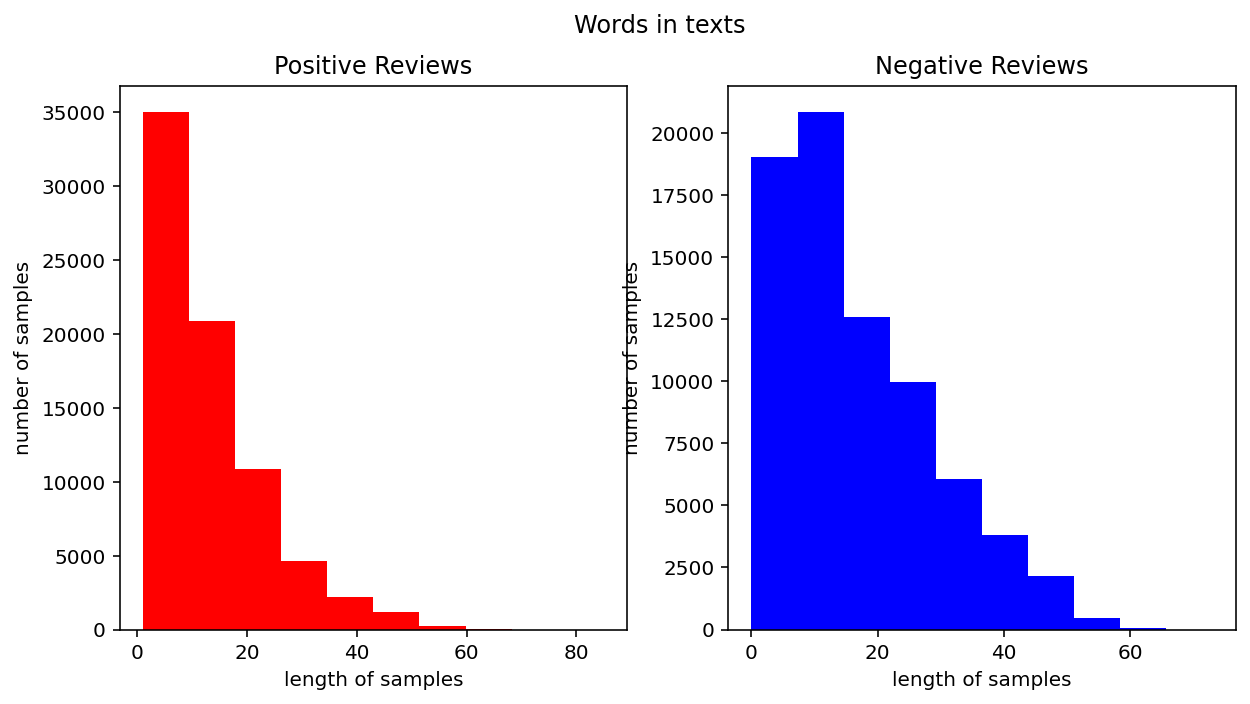

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [21]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

Vectorization

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [23]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39997
등장 빈도가 1번 이하인 희귀 단어의 수: 18212
단어 집합에서 희귀 단어의 비율: 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935259575621343


In [24]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21787


In [25]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
X_train[:3]

[[67,
  2060,
  299,
  14260,
  263,
  73,
  6,
  236,
  168,
  137,
  805,
  2951,
  625,
  2,
  77,
  62,
  207,
  40,
  1343,
  155,
  3,
  6],
 [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2],
 [46,
  24,
  825,
  105,
  35,
  2372,
  160,
  7,
  10,
  8061,
  4,
  1319,
  29,
  140,
  322,
  41,
  59,
  160,
  140,
  7,
  1916,
  2,
  113,
  162,
  1379,
  323,
  119,
  136]]

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307528129606286


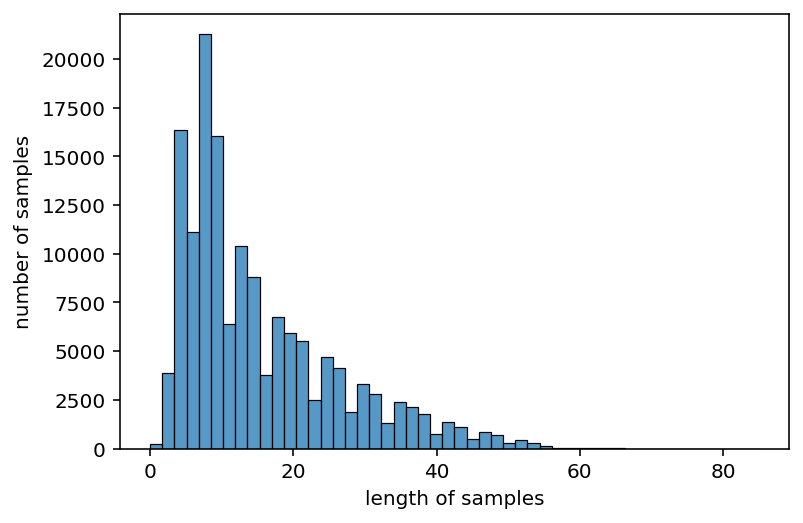

In [27]:
import seaborn as sns
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
sns.histplot([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [29]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


Padding

In [30]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# GRU 모델 이용해서 학습시키기

In [31]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [32]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [34]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - 41s 18ms/step - loss: 0.2701 - acc: 0.8980 - val_loss: 0.2266 - val_acc: 0.9169

Epoch 00001: val_acc improved from -inf to 0.91686, saving model to best_model.h5
Epoch 2/15
2000/2000 [==============================] - 35s 18ms/step - loss: 0.2143 - acc: 0.9228 - val_loss: 0.2101 - val_acc: 0.9242

Epoch 00002: val_acc improved from 0.91686 to 0.92420, saving model to best_model.h5
Epoch 3/15
2000/2000 [==============================] - 35s 18ms/step - loss: 0.1981 - acc: 0.9290 - val_loss: 0.2045 - val_acc: 0.9277

Epoch 00003: val_acc improved from 0.92420 to 0.92774, saving model to best_model.h5
Epoch 4/15
2000/2000 [==============================] - 35s 18ms/step - loss: 0.1870 - acc: 0.9336 - val_loss: 0.2012 - val_acc: 0.9289

Epoch 00004: val_acc improved from 0.92774 to 0.92890, saving model to best_model.h5
Epoch 5/15
2000/2000 [==============================] - 35s 18ms/step - loss: 0.1782 - acc: 0.9375 - val_loss: 0.20

In [35]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 10s 6ms/step - loss: 0.2078 - acc: 0.9262

 테스트 정확도: 0.9262


In [36]:
y_pred = loaded_model.predict(X_test)

In [37]:
y_pred=y_pred.round()

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

cm= confusion_matrix(y_test,y_pred)

In [39]:
ac= accuracy_score(y_test,y_pred)
print(ac)

0.9262260639894352


In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     25037
           1       0.92      0.93      0.93     24940

    accuracy                           0.93     49977
   macro avg       0.93      0.93      0.93     49977
weighted avg       0.93      0.93      0.93     49977



# LSTM을 이용해서 학습

In [41]:
from tensorflow.keras.layers import LSTM

model2 = Sequential()
model2.add(Embedding(vocab_size, 100))
model2.add(LSTM(128))
model2.add(Dense(1, activation='sigmoid'))

In [42]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [43]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model2.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - 41s 19ms/step - loss: 0.2777 - acc: 0.8959 - val_loss: 0.2367 - val_acc: 0.9126

Epoch 00001: val_acc improved from -inf to 0.91260, saving model to best_model_2.h5
Epoch 2/15
2000/2000 [==============================] - 38s 19ms/step - loss: 0.2178 - acc: 0.9211 - val_loss: 0.2542 - val_acc: 0.9085

Epoch 00002: val_acc did not improve from 0.91260
Epoch 3/15
2000/2000 [==============================] - 38s 19ms/step - loss: 0.2018 - acc: 0.9274 - val_loss: 0.2247 - val_acc: 0.9215

Epoch 00003: val_acc improved from 0.91260 to 0.92150, saving model to best_model_2.h5
Epoch 4/15
2000/2000 [==============================] - 38s 19ms/step - loss: 0.1909 - acc: 0.9323 - val_loss: 0.2050 - val_acc: 0.9266

Epoch 00004: val_acc improved from 0.92150 to 0.92663, saving model to best_model_2.h5
Epoch 5/15
2000/2000 [==============================] - 38s 19ms/step - loss: 0.1827 - acc: 0.9352 - val_loss: 0.2100 - val_acc: 0.9248

Epoch 0

In [44]:
loaded_model2 = load_model('best_model_2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model2.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 12s 7ms/step - loss: 0.2094 - acc: 0.9255

 테스트 정확도: 0.9255


In [45]:
y_pred2 = loaded_model2.predict(X_test)
y_pred2=y_pred2.round()

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     25037
           1       0.92      0.93      0.93     24940

    accuracy                           0.93     49977
   macro avg       0.93      0.93      0.93     49977
weighted avg       0.93      0.93      0.93     49977



따라서 더 성능이 좋은 GRU를 이용하기로 함

#워드 클라우드 생성

In [47]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측

  return score

In [48]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [49]:
cd /content/gdrive/My Drive/chung_proj

/content/gdrive/My Drive/chung_proj


In [50]:
train = pd.read_excel("../data/수산시장전체리뷰.xlsx")

In [51]:
import re
train['LABEL-14']=train['LABEL-14'].map(lambda x: re.sub('[-,=.#/?:$}]','', x))
train['LABEL-14'] = train['LABEL-14'].map(lambda x: re.sub(r'\d+', '', x))

In [52]:
train = train.reindex(columns = train.columns.tolist() + ["score_new"])

In [53]:
for i in range(len(train)):
  train['score_new'][i] = sentiment_predict(train['LABEL-14'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
train

,LABEL-1,LABEL-2,LABEL-3,LABEL-4,LABEL-5,LABEL-6,LABEL-7,LABEL-8,LABEL-9,LABEL-10,LABEL-11,LABEL-12,LABEL-13,LABEL-14,LABEL-15,LABEL-16,LABEL-17,LABEL-18,LABEL-19,LABEL-20,LABEL-21,LABEL-22,LABEL-23,LABEL-24,LABEL-25,score_new
0,https://lh3.googleusercontent.com/a-/AOh14Ghn9...,NaN,은밀하게위대확장,지역 가이드,· 리뷰 273개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,3달 전,신규,베스트웨스트군산점 숙소잡고 택시기사님추천으로\n비응항가서 대게를 대게대게실컷먹은날!!!,https://lh5.googleusercontent.com/p/AF1QipPqQL...,https://lh5.googleusercontent.com/p/AF1QipMDCr...,https://lh5.googleusercontent.com/p/AF1QipOk95...,https://lh5.googleusercontent.com/p/AF1QipPmzf...,6개 더보기,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.843851
1,https://lh3.googleusercontent.com/a/AATXAJzFio...,NaN,보따리,지역 가이드,· 리뷰 223개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,1달 전,신규,깔끔하고 친절한 횟집들이 많이 있습니다\n생선을 낚시로 잡아오면 무게를 재고 손질을...,NaN,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.983404
2,https://lh3.googleusercontent.com/a-/AOh14GiKp...,NaN,woo보리심,지역 가이드,리뷰 42개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,4달 전,신규,남동생내외와 함께 다녀온 군산여행~~모처럼 나들이라 재미도 있었는데 기차마을인지 철...,https://lh5.googleusercontent.com/p/AF1QipMm_Y...,https://lh5.googleusercontent.com/p/AF1QipOT99...,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.486135
3,https://lh3.googleusercontent.com/a-/AOh14GiXY...,NaN,마인드컨트롤,지역 가이드,· 리뷰 21개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,1달 전,신규,저두 일하러 가다보니 배도 고프고 코로나 때문에 북적거릴까 걱정했는데 생각보...,NaN,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.920791
4,https://lh3.googleusercontent.com/a-/AOh14GgDh...,NaN,다랑어,지역 가이드,· 리뷰 171개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,9달 전,신규,대방어포장해가서 아주 잘먹었습니디~,https://lh5.googleusercontent.com/p/AF1QipMZBx...,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.979945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,https://lh3.googleusercontent.com/a/AATXAJybEK...,NaN,정새롬,지역 가이드,· 리뷰 29개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,2년 전,신규,시장일뿐,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.

- 긍부정 문장들 나누기

In [55]:
train = train.reindex(columns = train.columns.tolist() + ["pos_neg"])

In [56]:
train

,LABEL-1,LABEL-2,LABEL-3,LABEL-4,LABEL-5,LABEL-6,LABEL-7,LABEL-8,LABEL-9,LABEL-10,LABEL-11,LABEL-12,LABEL-13,LABEL-14,LABEL-15,LABEL-16,LABEL-17,LABEL-18,LABEL-19,LABEL-20,LABEL-21,LABEL-22,LABEL-23,LABEL-24,LABEL-25,score_new,pos_neg
0,https://lh3.googleusercontent.com/a-/AOh14Ghn9...,NaN,은밀하게위대확장,지역 가이드,· 리뷰 273개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,3달 전,신규,베스트웨스트군산점 숙소잡고 택시기사님추천으로\n비응항가서 대게를 대게대게실컷먹은날!!!,https://lh5.googleusercontent.com/p/AF1QipPqQL...,https://lh5.googleusercontent.com/p/AF1QipMDCr...,https://lh5.googleusercontent.com/p/AF1QipOk95...,https://lh5.googleusercontent.com/p/AF1QipPmzf...,6개 더보기,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.843851,NaN
1,https://lh3.googleusercontent.com/a/AATXAJzFio...,NaN,보따리,지역 가이드,· 리뷰 223개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,1달 전,신규,깔끔하고 친절한 횟집들이 많이 있습니다\n생선을 낚시로 잡아오면 무게를 재고 손질을...,NaN,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.983404,NaN
2,https://lh3.googleusercontent.com/a-/AOh14GiKp...,NaN,woo보리심,지역 가이드,리뷰 42개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,4달 전,신규,남동생내외와 함께 다녀온 군산여행~~모처럼 나들이라 재미도 있었는데 기차마을인지 철...,https://lh5.googleusercontent.com/p/AF1QipMm_Y...,https://lh5.googleusercontent.com/p/AF1QipOT99...,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.486135,NaN
3,https://lh3.googleusercontent.com/a-/AOh14GiXY...,NaN,마인드컨트롤,지역 가이드,· 리뷰 21개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,1달 전,신규,저두 일하러 가다보니 배도 고프고 코로나 때문에 북적거릴까 걱정했는데 생각보...,NaN,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.920791,NaN
4,https://lh3.googleusercontent.com/a-/AOh14GgDh...,NaN,다랑어,지역 가이드,· 리뷰 171개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,9달 전,신규,대방어포장해가서 아주 잘먹었습니디~,https://lh5.googleusercontent.com/p/AF1QipMZBx...,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.979945,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,https://lh3.googleusercontent.com/a/AATXAJybEK...,NaN,정새롬,지역 가이드,· 리뷰 29개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,2년 전,신규,시장일뿐,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/ico

In [57]:
for i in range(len(train)):
  if train['score_new'][i] > 0.5:
    train['pos_neg'][i]= "긍정"
  else:
    train['pos_neg'][i]= "부정"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [58]:
neg =train[train['pos_neg'] == '부정']
neg

,LABEL-1,LABEL-2,LABEL-3,LABEL-4,LABEL-5,LABEL-6,LABEL-7,LABEL-8,LABEL-9,LABEL-10,LABEL-11,LABEL-12,LABEL-13,LABEL-14,LABEL-15,LABEL-16,LABEL-17,LABEL-18,LABEL-19,LABEL-20,LABEL-21,LABEL-22,LABEL-23,LABEL-24,LABEL-25,score_new,pos_neg
2,https://lh3.googleusercontent.com/a-/AOh14GiKp...,NaN,woo보리심,지역 가이드,리뷰 42개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,4달 전,신규,남동생내외와 함께 다녀온 군산여행~~모처럼 나들이라 재미도 있었는데 기차마을인지 철...,https://lh5.googleusercontent.com/p/AF1QipMm_Y...,https://lh5.googleusercontent.com/p/AF1QipOT99...,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.486135,부정
8,https://lh3.googleusercontent.com/a/AATXAJypgH...,NaN,핀셰,지역 가이드,리뷰 2개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,11달 전,신규,즉석에서 우럭과 광어 두마리 잡아서 식당에서 회쳐먹구 매운탕까지! 크ㅠ 매운탈 특히...,https://lh5.googleusercontent.com/p/AF1QipPYWc...,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.252992,부정
12,https://lh3.googleusercontent.com/a/AATXAJzFzs...,NaN,양권석,지역 가이드,· 리뷰 16개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,3달 전,신규,싱싱한해산물이 가득~^~^,https://lh5.googleusercontent.com/p/AF1QipP39h...,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.444838,부정
23,https://lh3.googleusercontent.com/a-/AOh14GjiZ...,NaN,기동전사,지역 가이드,· 리뷰 17개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,1년 전,신규,싸고 많이줌,https://lh5.googleusercontent.com/p/AF1QipON1B...,https://lh5.googleusercontent.com/p/AF1QipOz1T...,https://lh5.googleusercontent.com/p/AF1QipMBXm...,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.160569,부정
24,https://lh3.googleusercontent.com/a/AATXAJzJNN...,NaN,김문수,지역 가이드,리뷰 10개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,6달 전,신규,위치는 좋은데 횟값이 생각보다 비싸네요;,NaN,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.241178,부정
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,https://lh3.googleusercontent.com/a-/AOh14GhXt...,NaN,앙곰,지역 가이드,· 리뷰 275개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,2년 전,신규,안싸,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,NaN,0.06580

In [59]:
#불용어 제거, token화 시키기
def text_preprocessing(text_list):
    
    stopwords = ['을', '를', '가','도','이','또는','및','의','은', '는','로','과','null'] #불용어 설정
    tokenizer = Mecab() #형태소 분석기 
    token_list = []
    
    for content in text_list:
        txt = re.sub('[^가-힣a-z]', ' ', str(content)) #한글이랑 영어 소문자만 남기고 다른 글자 모두 제거
        token = tokenizer.morphs(txt) #형태소 분석
        token = [t for t in token if t not in stopwords and type(t) != float] #형태소 분석 결과 중 stopwords에 해당하지 않는 것만 추출
        token_list.append(token)     
    
    return token_list, tokenizer
#token_list에는 쪼개진 단어(token)들이 들어있음

In [60]:
plt.rc('font', family='NanumBarunGothic') 

In [61]:
import konlpy
from konlpy.tag import Mecab
import re

In [62]:
neg =neg['LABEL-14']

In [63]:
review_neg, mecab = text_preprocessing(neg)

In [64]:
#token들을 하나의 list로 합쳐주기!
result = []
for i in range(len(review_neg)):
  result.extend(review_neg[i])

In [65]:
import nltk
from nltk import collocations

from konlpy.tag import Okt, Kkma
from konlpy.utils import pprint

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='NanumBarunGothic') 

In [66]:
ko = nltk.Text(result)

부정 워드클라우드

In [67]:
mask = Image.open('thumb2.png')
mask = np.array(mask)

In [68]:
def wc(ko,num_words_):
    print( '단어수:',len(ko.tokens) , '안겹치는단어수:', len(set(ko.tokens)) )
    plt.figure(figsize=(12,5))
    ko.plot(50)
    plt.show()
    
    num_words = num_words_
    data = ko.vocab().most_common(num_words)
    wordcloud = WordCloud( colormap = 'Reds',max_font_size=1000,background_color='white', font_path='/content/gdrive/MyDrive/chung_proj/BMDOHYEON_ttf.ttf', mask = mask).generate_from_frequencies(dict(data))
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [69]:
#추가불용어정의
불용어 = []
def add_stopwords(x):
    불용어.append(x)

In [70]:
add_stopwords('너무')
add_stopwords('정말')
add_stopwords('가') 
add_stopwords('도')
add_stopwords('진짜') 
add_stopwords('네요') 
add_stopwords('어요') 
add_stopwords('요')
add_stopwords('진짜') 
add_stopwords('카페') 
add_stopwords('커피') 
add_stopwords('아요') 
add_stopwords('는데')
add_stopwords('아요') 
add_stopwords('습니다')
add_stopwords('에서')  
add_stopwords('해요') 
add_stopwords('지만') 
add_stopwords('합니다') 
add_stopwords('인데')
add_stopwords('으로') 
add_stopwords('세요')
add_stopwords('입니다') 
add_stopwords('그리고')
add_stopwords('어서') 
add_stopwords('에요') 
add_stopwords('면서') 
add_stopwords('해서') 
add_stopwords('라고') 
add_stopwords('아서') 
add_stopwords('으면') 
add_stopwords('은데') 
add_stopwords('까지') 
add_stopwords('인지') 
add_stopwords('으나') 
add_stopwords('이나') 
add_stopwords('구요')
add_stopwords('oogle')
add_stopwords('아니')
add_stopwords('정도')
add_stopwords('수산') 
add_stopwords('시장') 
add_stopwords('는지') 
add_stopwords('마다') 
add_stopwords('때문') 
add_stopwords('다고') 
add_stopwords('보다')
add_stopwords('많이')  

In [71]:
ko_elim = [ x for x in ko if (x not in 불용어) & (len(x)>1) ]
print( len(ko), len(ko_elim) )
ko_elim = nltk.Text(ko_elim)

5903 2512


단어수: 2512 안겹치는단어수: 1086


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49912 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_

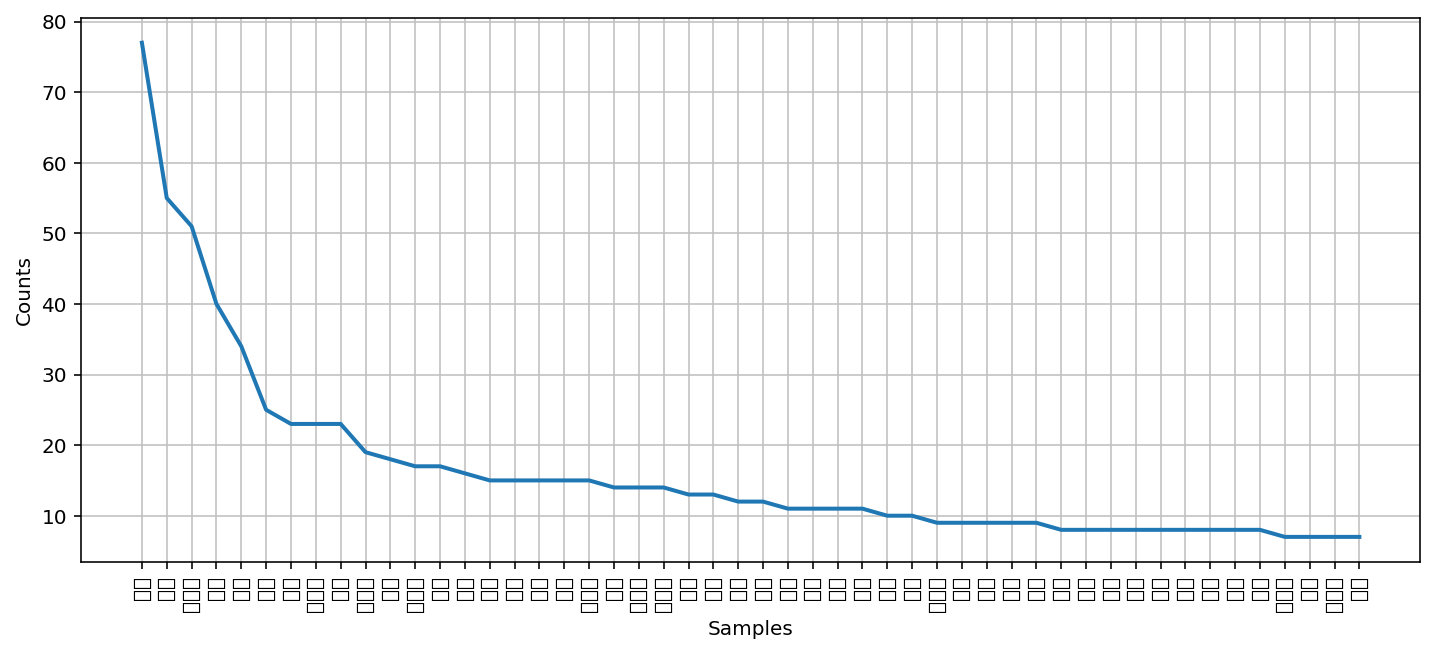

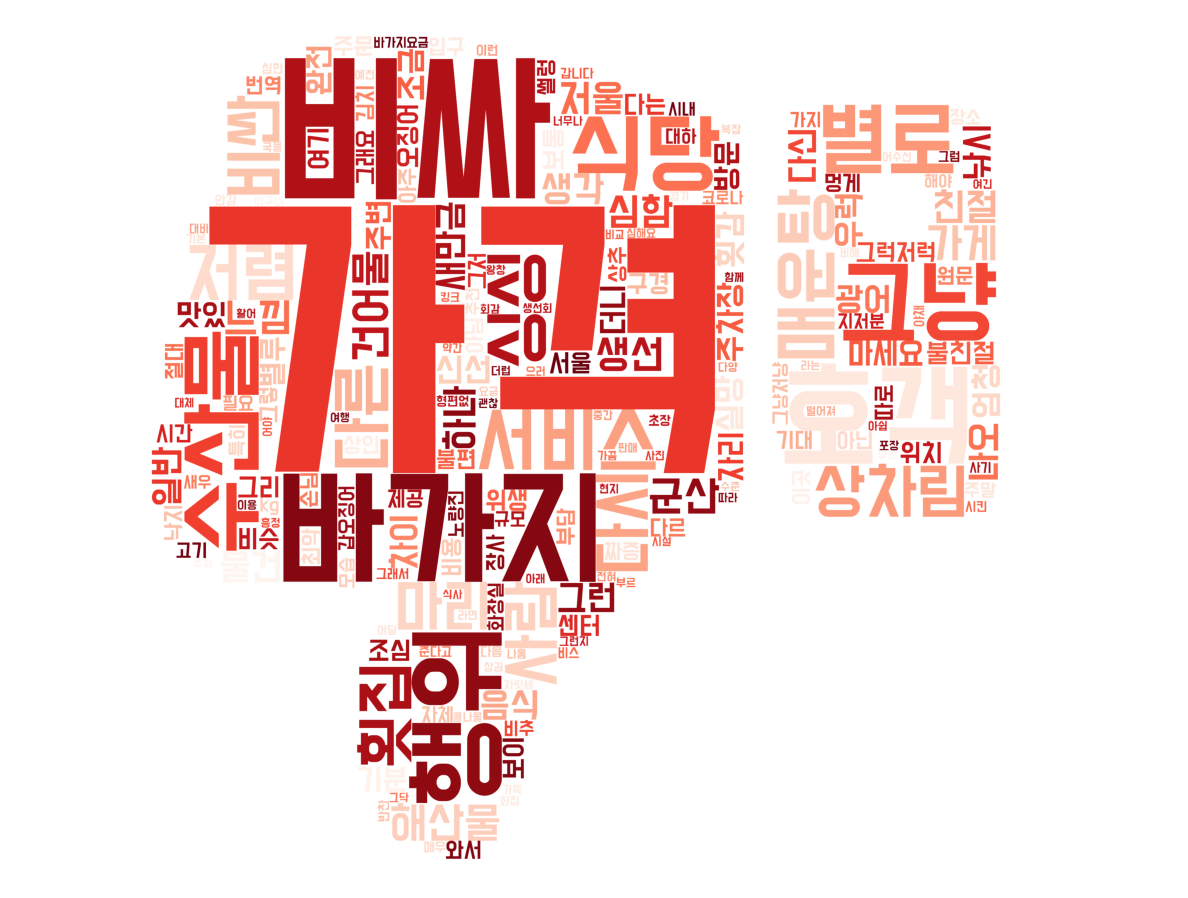

In [72]:
wc(ko_elim,500)

#긍정

In [73]:
pos =train[train['pos_neg'] == '긍정']
pos

,LABEL-1,LABEL-2,LABEL-3,LABEL-4,LABEL-5,LABEL-6,LABEL-7,LABEL-8,LABEL-9,LABEL-10,LABEL-11,LABEL-12,LABEL-13,LABEL-14,LABEL-15,LABEL-16,LABEL-17,LABEL-18,LABEL-19,LABEL-20,LABEL-21,LABEL-22,LABEL-23,LABEL-24,LABEL-25,score_new,pos_neg
0,https://lh3.googleusercontent.com/a-/AOh14Ghn9...,NaN,은밀하게위대확장,지역 가이드,· 리뷰 273개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,3달 전,신규,베스트웨스트군산점 숙소잡고 택시기사님추천으로\n비응항가서 대게를 대게대게실컷먹은날!!!,https://lh5.googleusercontent.com/p/AF1QipPqQL...,https://lh5.googleusercontent.com/p/AF1QipMDCr...,https://lh5.googleusercontent.com/p/AF1QipOk95...,https://lh5.googleusercontent.com/p/AF1QipPmzf...,6개 더보기,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.843851,긍정
1,https://lh3.googleusercontent.com/a/AATXAJzFio...,NaN,보따리,지역 가이드,· 리뷰 223개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,1달 전,신규,깔끔하고 친절한 횟집들이 많이 있습니다\n생선을 낚시로 잡아오면 무게를 재고 손질을...,NaN,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.983404,긍정
3,https://lh3.googleusercontent.com/a-/AOh14GiXY...,NaN,마인드컨트롤,지역 가이드,· 리뷰 21개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,1달 전,신규,저두 일하러 가다보니 배도 고프고 코로나 때문에 북적거릴까 걱정했는데 생각보...,NaN,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.920791,긍정
4,https://lh3.googleusercontent.com/a-/AOh14GgDh...,NaN,다랑어,지역 가이드,· 리뷰 171개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,9달 전,신규,대방어포장해가서 아주 잘먹었습니디~,https://lh5.googleusercontent.com/p/AF1QipMZBx...,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.979945,긍정
5,https://lh3.googleusercontent.com/a/AATXAJwmEO...,NaN,오금주,지역 가이드,리뷰 20개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,4달 전,신규,멸치와 마른 홍합을 구매 했는데요 상품도 좋구요 젊은 부부 인데 서비스가 아주 좋았...,NaN,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,0.990183,긍정
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,https://lh3.googleusercontent.com/a/AATXAJzUsj...,NaN,꽃보다꽃등심,지역 가이드,리뷰 6개,https://www.gstatic.com/images/icons/material/...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,https://maps.gstatic.com/consumer/images/icons...,1년 전,신규,가성비별로,NaN,NaN,NaN,NaN,https://www.gstatic.com/images/icons/material/...,좋아요,https://www.gstatic.com/images/icons/material/...,공유,NaN,NaN,NaN,0.532402,긍정
79

In [74]:
pos =pos['LABEL-14']

In [75]:
review_pos, mecab = text_preprocessing(pos)

In [76]:
#token들을 하나의 list로 합쳐주기!
result2 = []
for i in range(len(review_pos)):
  result2.extend(review_pos[i])

In [77]:
mask2 = Image.open('thumb3.png')
mask2 = np.array(mask2)

In [78]:
def wc(ko,num_words_):
    print( '단어수:',len(ko.tokens) , '안겹치는단어수:', len(set(ko.tokens)) )
    plt.figure(figsize=(12,5))
    ko.plot(50)
    plt.show()
    
    num_words = num_words_
    data = ko.vocab().most_common(num_words)
    wordcloud = WordCloud( colormap = 'Blues',background_color='white',max_font_size=1000, font_path='/content/gdrive/MyDrive/chung_proj/BMDOHYEON_ttf.ttf', mask = mask2).generate_from_frequencies(dict(data))
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [79]:
ko2 = nltk.Text(result2)

In [80]:
add_stopwords('oogle')
add_stopwords('번역')

In [81]:
ko_elim2 = [ x for x in ko2 if (x not in 불용어) & (len(x)>1) ]
print( len(ko2), len(ko_elim2) )
ko_elim2 = nltk.Text(ko_elim2)

4070 1612


단어수: 1612 안겹치는단어수: 766


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49905 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47579 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51080 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_

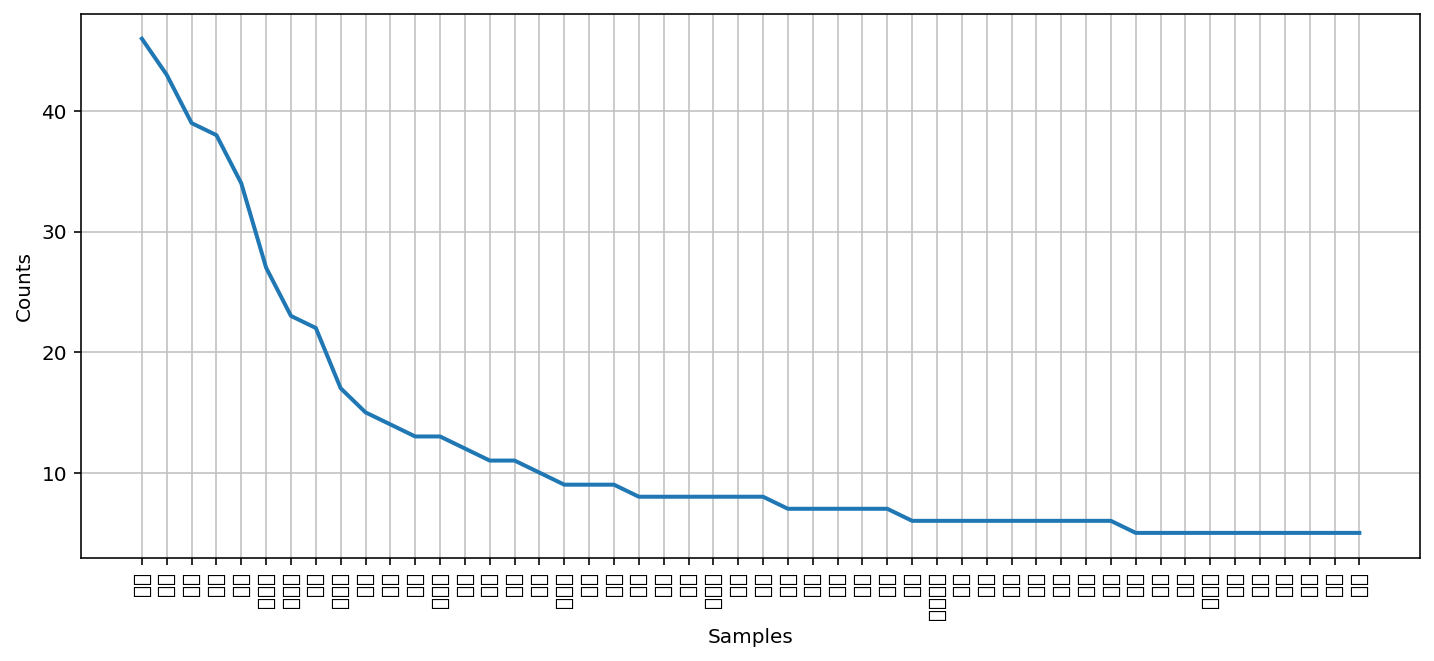

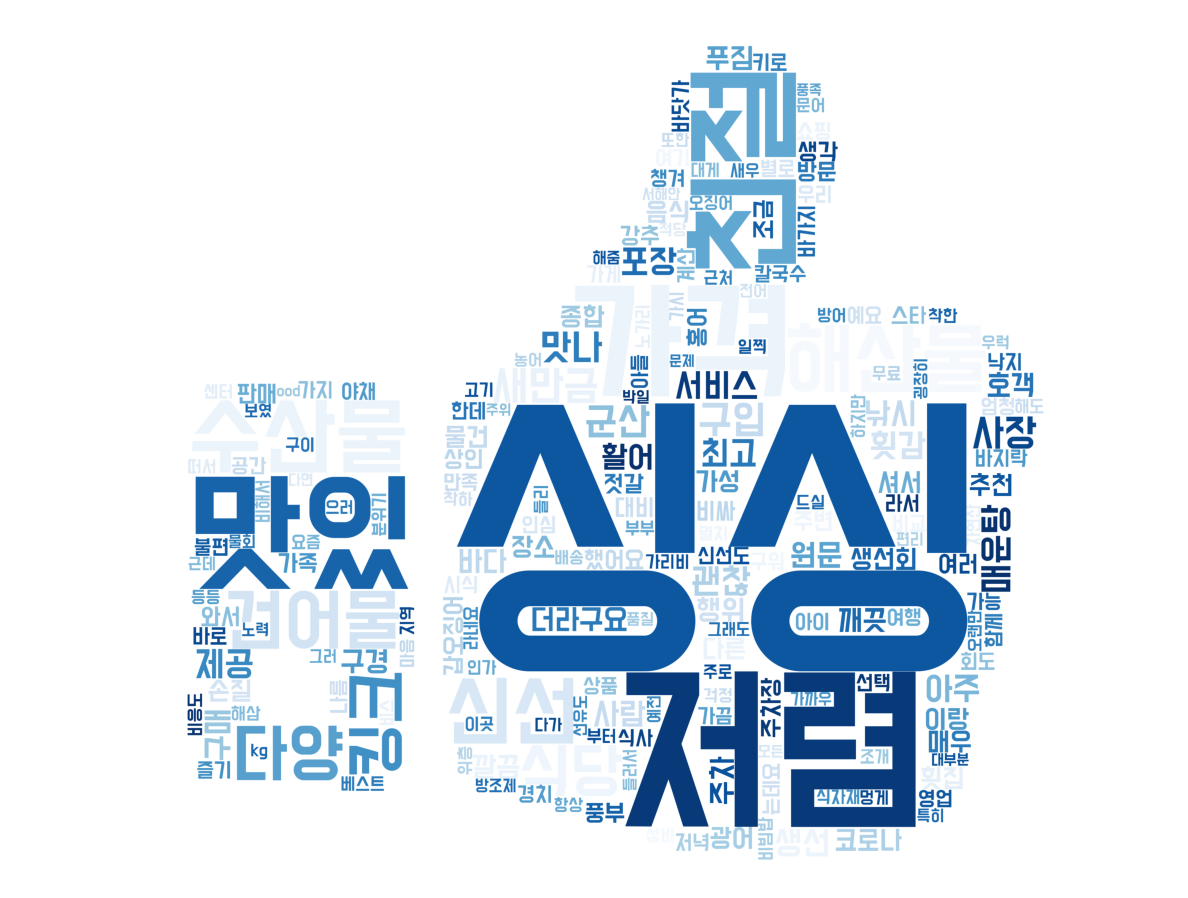

In [82]:
wc(ko_elim2,500)